## Step2.1: Features Extractions

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import shannon_entropy
from tqdm import tqdm

# Dataset path
dataset_dir = '../data/Duke-Breast-Cancer-MRI'
patient_dirs = sorted(os.listdir(dataset_dir))[:100]

# Feature extractor
def extract_features_from_image(img):
    features = {}
    img = img.astype(np.uint8)
    features['mean'] = np.mean(img)
    features['std'] = np.std(img)
    features['min'] = np.min(img)
    features['max'] = np.max(img)
    features['entropy'] = shannon_entropy(img)

    try:
        glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
        features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]
        features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
        features['energy'] = graycoprops(glcm, 'energy')[0, 0]
        features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    except:
        features.update({k: 0 for k in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']})

    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    for i, val in enumerate(hist):
        features[f'lbp_{i}'] = val

    return features

# Process all patients
all_features = []

for patient in tqdm(patient_dirs):
    try:
        patient_path = os.path.join(dataset_dir, patient)
        first_level = sorted(os.listdir(patient_path))[0]
        second_path = os.path.join(patient_path, first_level)
        third_level = sorted(os.listdir(second_path))[0]
        dicom_dir = os.path.join(second_path, third_level)

        dicom_files = sorted([f for f in os.listdir(dicom_dir) if f.endswith('.dcm')])[:5]
        if len(dicom_files) < 5:
            continue  # Skip if insufficient slices

        patient_features = []

        for dcm_file in dicom_files:
            dcm_path = os.path.join(dicom_dir, dcm_file)
            ds = pydicom.dcmread(dcm_path)
            img = ds.pixel_array
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6) * 255
            img = img.astype(np.uint8)
            feats = extract_features_from_image(img)
            patient_features.append(feats)

        # Average all features across 30 slices
        patient_df = pd.DataFrame(patient_features)
        mean_feats = patient_df.mean().to_dict()
        mean_feats['patient_id'] = patient
        all_features.append(mean_feats)

    except Exception as e:
        print(f"Error with patient {patient}: {e}")

# Save to CSV
features_df = pd.DataFrame(all_features)
features_df.to_csv("extracted_radiomics_features.csv", index=False)
print("Radiomic feature extraction completed and saved for 30 slices per patient.")


100%|█████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


✅ Radiomic feature extraction completed and saved for 30 slices per patient.


## Step 2.2: Feature Selection

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
clinical_df = pd.read_excel('../data/Clinical_and_Other_Features.xlsx', header=0, skiprows=[0, 2])
features_df = pd.read_csv('extracted_radiomics_features.csv')

# Merge datasets
merged_df = pd.merge(clinical_df, features_df, on='Patient ID', how='inner')

# Drop rows where tumor grade is missing
merged_df = merged_df.dropna(subset=['Tumor Grade'])

# Now redefine X and tumor_grade after filtering
tumor_grade = merged_df['Tumor Grade']
calcifications = merged_df['Calcifications']

# Get feature columns (exclude targets and non-feature columns)
exclude_cols = ['Patient ID', 'file_path', 'Tumor Grade', 'Calcifications'] 
feature_cols = [col for col in merged_df.columns if col not in exclude_cols]

# Recalculate feature columns
X = merged_df[[col for col in merged_df.columns if col not in ['Patient ID', 'file_path', 'Tumor Grade', 'Calcifications']]]
X = X.select_dtypes(include=[np.number])

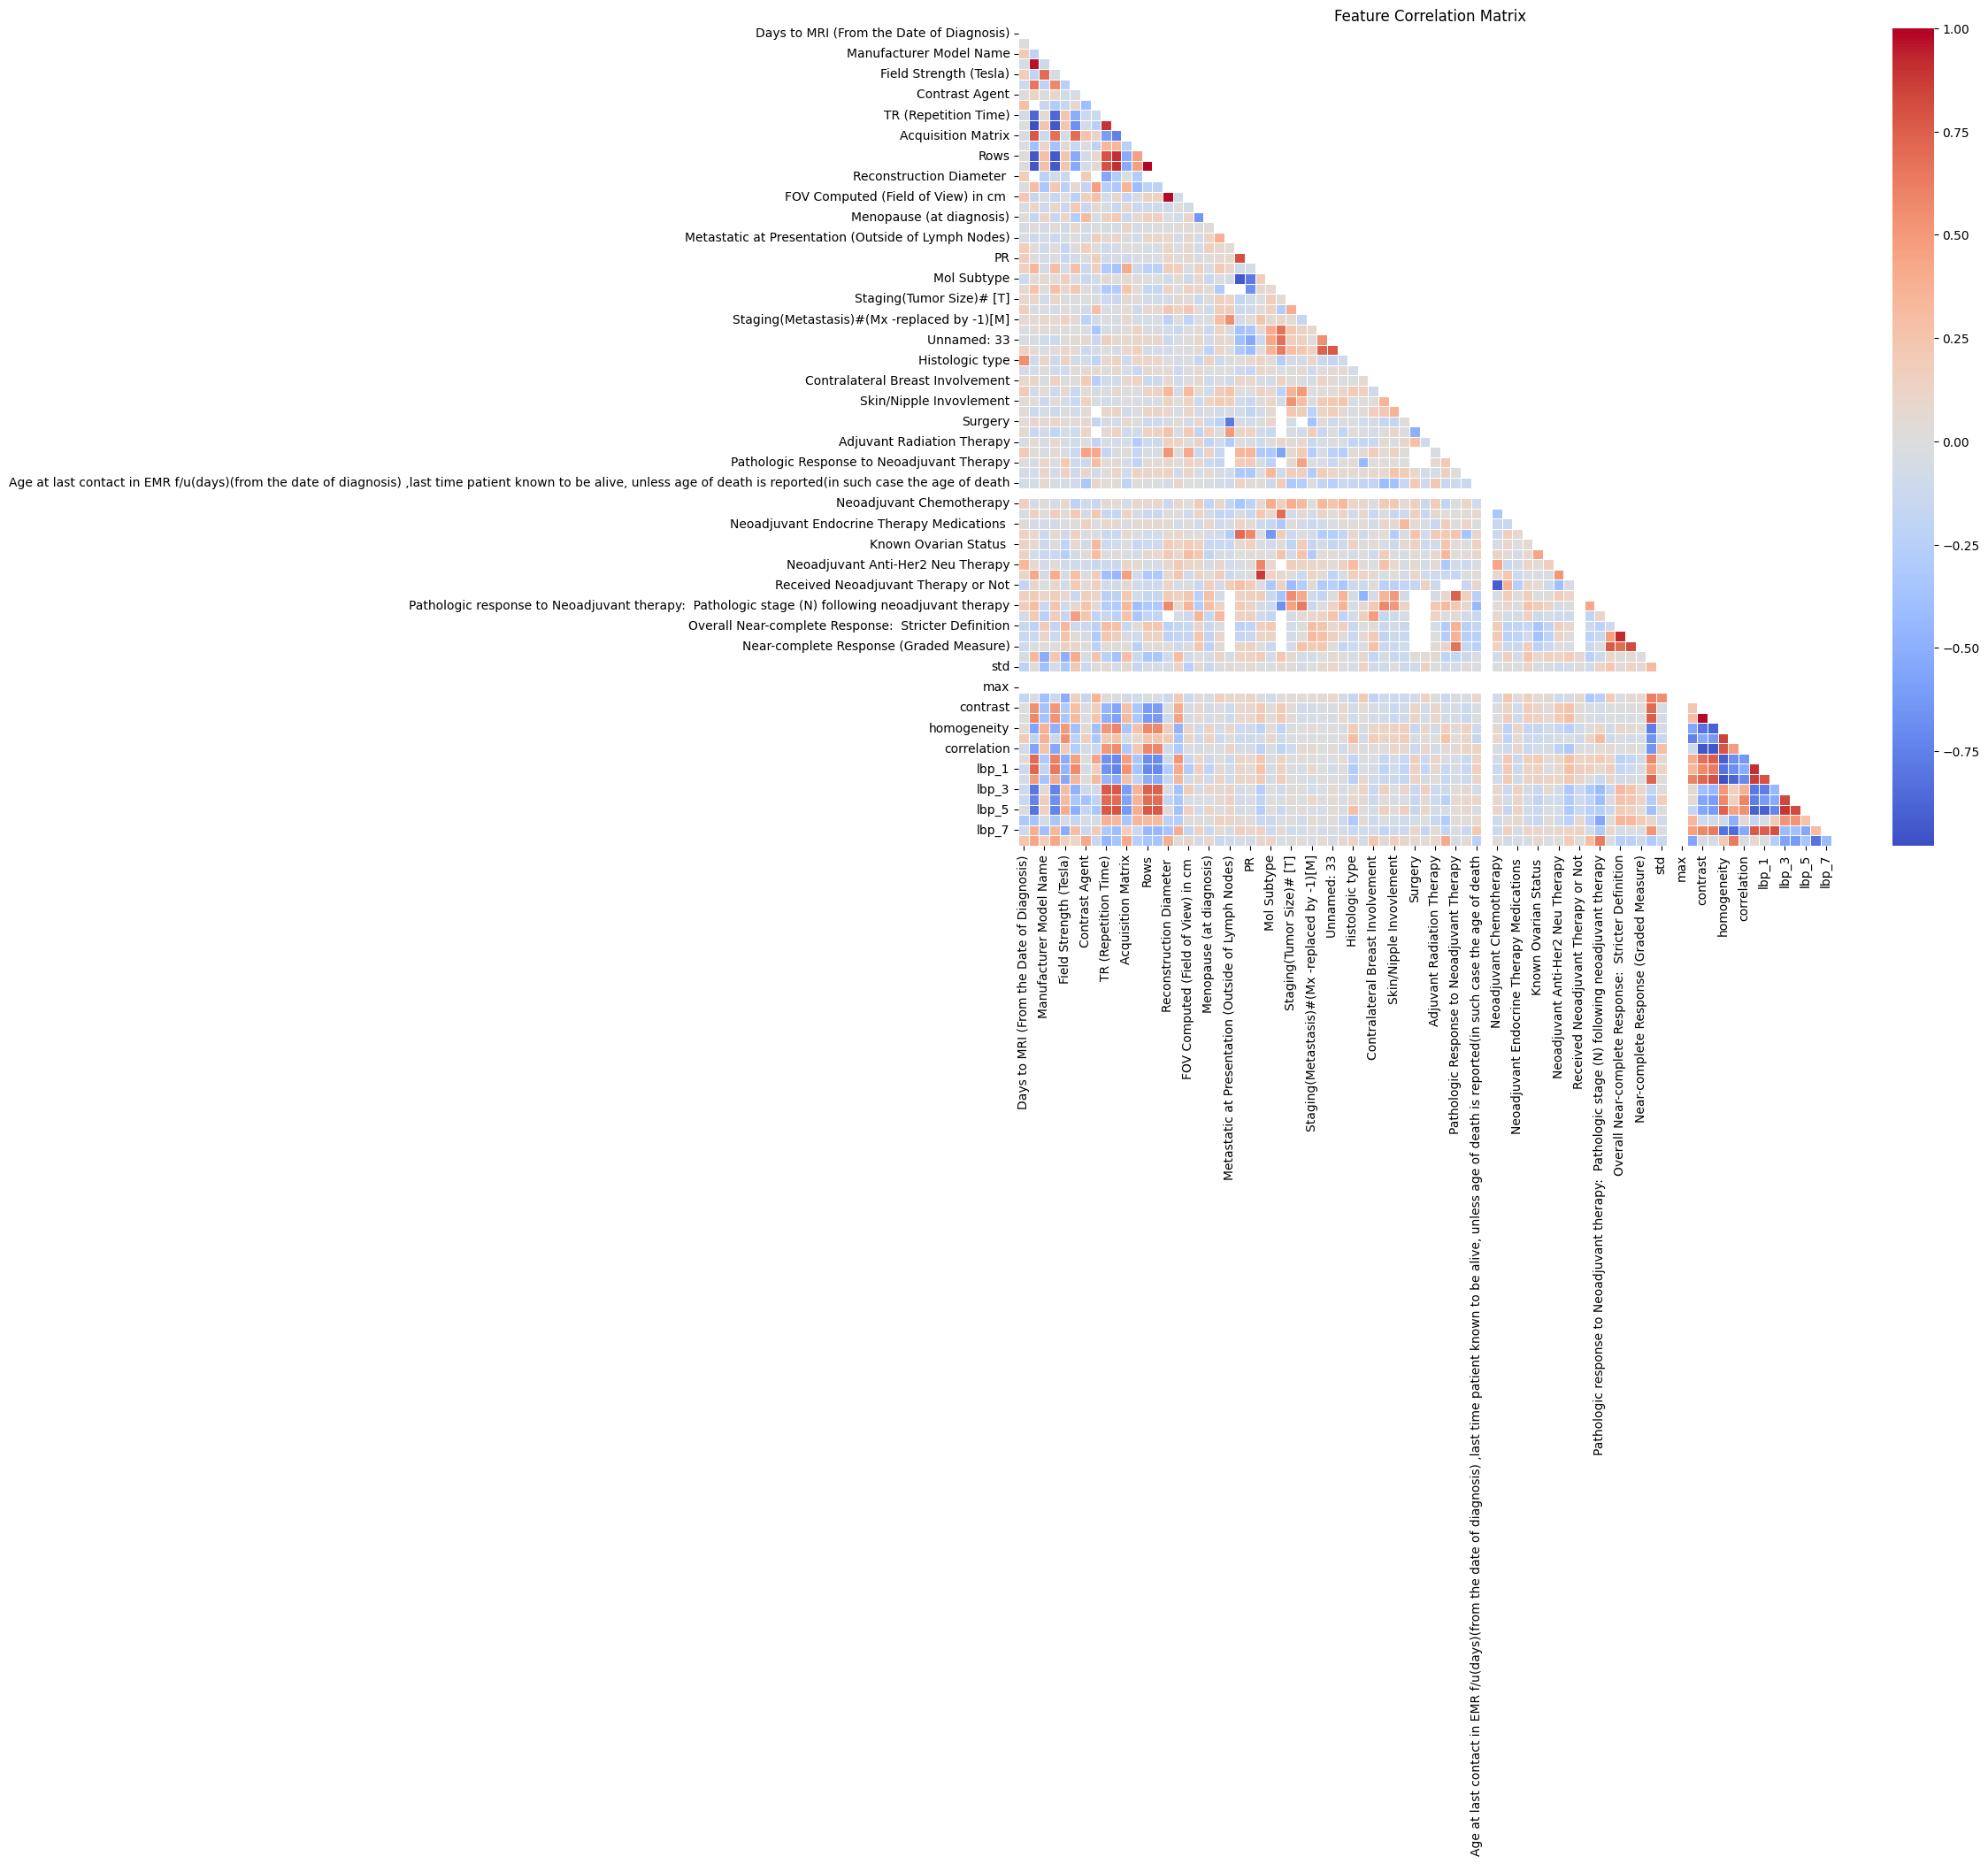

In [3]:
# 1. Feature correlation analysis
plt.figure(figsize=(15, 12))
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show('feature_correlation.png')
plt.close()

/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


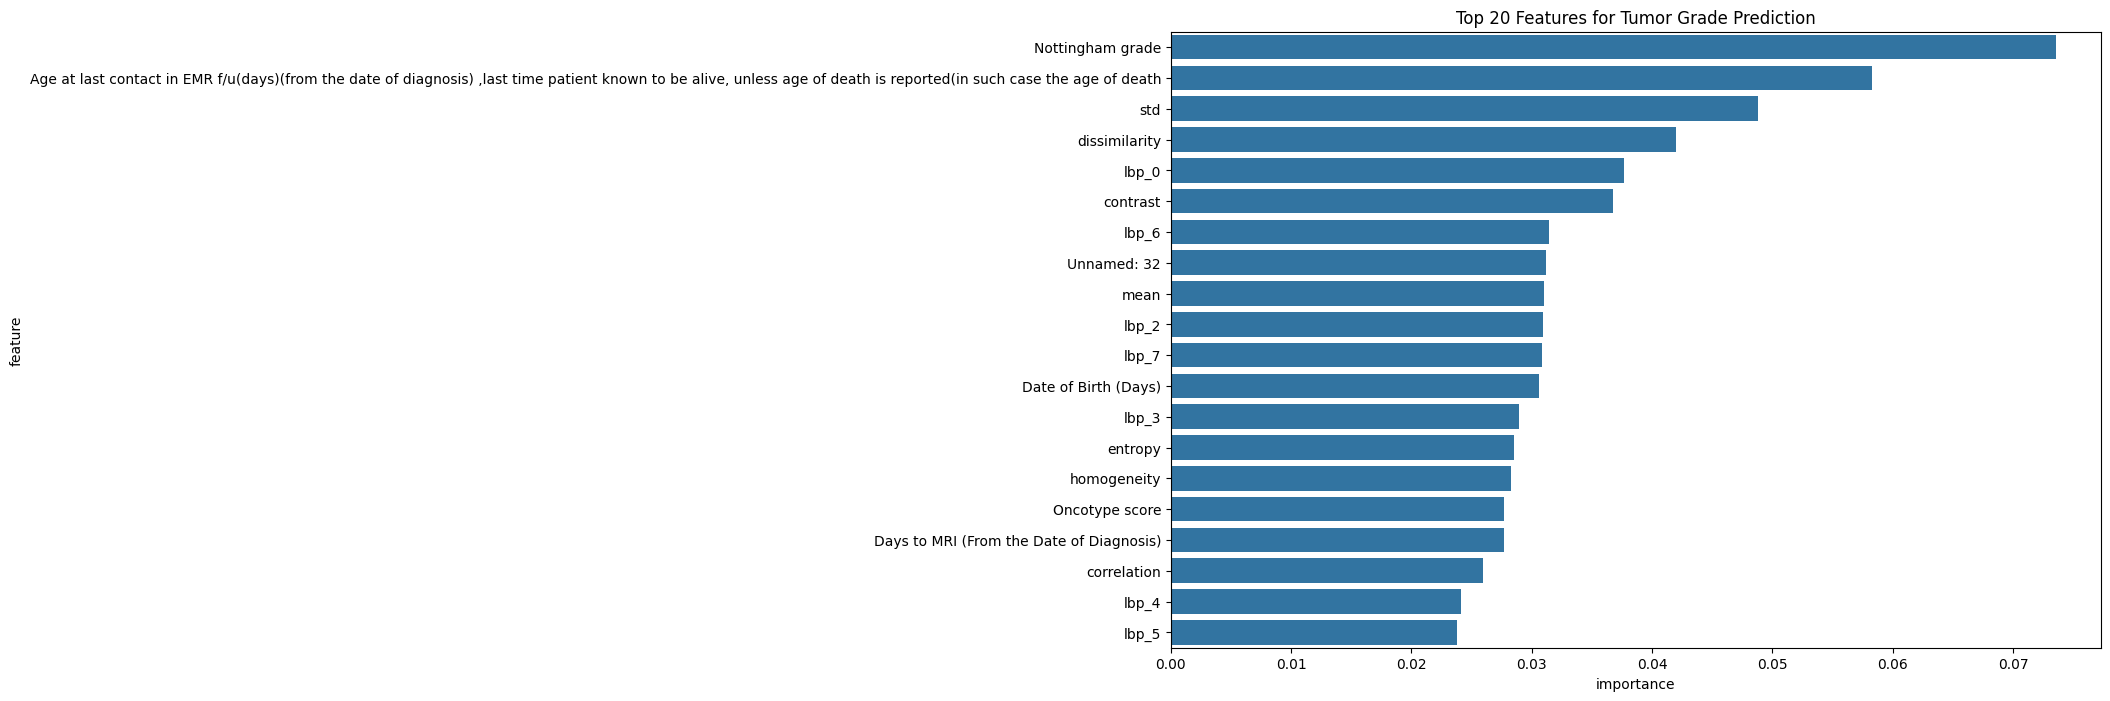

Number of NaN in Features: 859
Number of NaN in Calcifications: 21


In [4]:
# 2. Feature importance for Tumor Grade prediction using RandomForest
X_scaled = StandardScaler().fit_transform(X)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, tumor_grade)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Features for Tumor Grade Prediction')
plt.show('feature_importance_tumor_grade.png')
plt.close()

# Check for NaN in features and target
print("Number of NaN in Features:", np.isnan(X_scaled).sum())
print("Number of NaN in Calcifications:", calcifications.isnull().sum())

In [5]:
merged_df = merged_df.dropna(subset=['Tumor Grade']).reset_index(drop=True)
# Define targets again
tumor_grade = merged_df['Tumor Grade']
calcifications = merged_df['Calcifications']

# Define features again
exclude_cols = ['Patient ID', 'file_path', 'Tumor Grade', 'Calcifications']
feature_cols = [col for col in merged_df.columns if col not in exclude_cols]
X = merged_df[feature_cols].select_dtypes(include=[np.number])

# Drop samples where target 'calcifications' is NaN
valid_idx = calcifications.dropna().index
X_scaled_valid = X_scaled[valid_idx]

# Fix NaNs in Labels (already done)
calcifications_valid = calcifications.loc[valid_idx]

# Fix NaNs in Features
imputer = SimpleImputer(strategy='median')
X_scaled_valid_imputed = imputer.fit_transform(X_scaled_valid)

# Clean calcifications target properly
calcifications_valid_clean = calcifications_valid.copy()

# Mapping rules
# "NC" --> 0 (no calcifications)
# 0-7 --> 1 (presence of calcifications)
mapping = {
    'NC': 0,
    '0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1,
    0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1
}

# Apply mapping
calcifications_valid_clean = calcifications_valid_clean.map(mapping)

# Drop any NaNs remaining
calcifications_valid_clean = calcifications_valid_clean.dropna().astype(int)

# Align feature matrix
X_scaled_valid_imputed = X_scaled_valid_imputed[:len(calcifications_valid_clean)]

/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [45]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [6]:
# Feature selection
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=30)
rfe.fit(X_scaled_valid, calcifications_valid_clean)

# Get selected features
selected_features_rfe = pd.DataFrame({
    'feature': X.columns,
    'selected': rfe.support_
})
selected_features_list = selected_features_rfe[selected_features_rfe['selected']]['feature'].tolist()
print(f"Selected features using RFE: {selected_features_list}")

# 4. Statistical feature selection using ANOVA F-test
imputer_full = SimpleImputer(strategy='median')
X_scaled_imputed = imputer_full.fit_transform(X_scaled)

# Make sure the feature names are aligned
actual_n_features = X_scaled_imputed.shape[1]
feature_names = X.columns[:actual_n_features].tolist()
X_scaled_imputed_df = pd.DataFrame(X_scaled_imputed, columns=feature_names)

Selected features using RFE: ['TR (Repetition Time)', 'Acquisition Matrix', 'Rows', 'Columns', 'Reconstruction Diameter ', 'Oncotype score', 'Nottingham grade', 'Histologic type', 'Skin/Nipple Invovlement', 'Age at last contact in EMR f/u(days)(from the date of diagnosis) ,last time patient known to be alive, unless age of death is reported(in such case the age of death', 'Neoadjuvant Endocrine Therapy Medications ', 'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ', 'Overall Near-complete Response:  Looser Definition', 'mean', 'std', 'entropy', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'lbp_0', 'lbp_1', 'lbp_2', 'lbp_3', 'lbp_4', 'lbp_5', 'lbp_6', 'lbp_7', 'lbp_8']


/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [45]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [7]:
# For Tumor Grade
selector_f = SelectKBest(score_func=f_classif, k=30)

selector_f.fit(X_scaled_imputed_df, tumor_grade)

selected_features_f = pd.DataFrame({
    'feature': feature_names,
    'score': selector_f.scores_,
    'pvalue': selector_f.pvalues_
}).sort_values('score', ascending=False)

print("Top features selected using ANOVA F-test for Tumor Grade:")
print(selected_features_f.head(20))

X_scaled_imputed_df_valid = X_scaled_imputed_df.loc[calcifications_valid_clean.index]

Top features selected using ANOVA F-test for Tumor Grade:
                                              feature      score        pvalue
31                                   Nottingham grade  20.756632  3.319448e-08
29                                        Unnamed: 32  13.948998  4.880824e-06
30                                        Unnamed: 33   4.821489  1.013076e-02
18                           Menopause (at diagnosis)   4.181160  1.818295e-02
53                    Adjuvant Anti-Her2 Neu Therapy    4.024588  2.100179e-02
46                           Neoadjuvant Chemotherapy   3.576370  3.180499e-02
45                                        Unnamed: 67   3.020329  5.349380e-02
24                                        Mol Subtype   2.860705  6.217069e-02
35                Lymphadenopathy or Suspicious Nodes   2.671468  7.434438e-02
44  Age at last contact in EMR f/u(days)(from the ...   2.360732  9.986442e-02
25                                     Oncotype score   2.246011  1.11411

/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [62 63] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [8]:
# For Calcifications
selector_f2 = SelectKBest(score_func=f_classif, k=30)
selector_f2.fit(X_scaled_imputed_df_valid, calcifications_valid_clean)

selected_features_f2 = pd.DataFrame({
    'feature': X_scaled_imputed_df_valid.columns,
    'score': selector_f2.scores_,
    'pvalue': selector_f2.pvalues_
}).sort_values('score', ascending=False)

print("Top features selected using ANOVA F-test for Calcifications:")
print(selected_features_f2.head(20))

# Save the selected features
pd.DataFrame({'tumor_grade_features': selected_features_f.head(30)['feature']}).to_csv('tumor_grade_features.csv', index=False)
pd.DataFrame({'calcifications_features': selected_features_f2.head(30)['feature']}).to_csv('calcifications_features.csv', index=False)

Top features selected using ANOVA F-test for Calcifications:
                                    feature     score    pvalue
74                                    lbp_3  5.627831  0.020243
10                       Acquisition Matrix  4.555124  0.036089
76                                    lbp_5  3.921949  0.051328
78                                    lbp_7  3.894092  0.052141
47                    Adjuvant Chemotherapy  3.422427  0.068255
73                                    lbp_2  3.109964  0.081887
6                            Contrast Agent  3.107094  0.082026
46                 Neoadjuvant Chemotherapy  2.029221  0.158448
49  Adjuvant Endocrine Therapy Medications   1.792208  0.184701
4                    Field Strength (Tesla)  1.619787  0.207053
8                      TR (Repetition Time)  1.502684  0.224094
75                                    lbp_4  1.425042  0.236338
5               Patient Position During MRI  1.370851  0.245372
18                 Menopause (at diagnosis)

/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [62 63] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Step 2.3: Deep Learning Feature Extraction with EfficientNetB7

In [9]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pydicom
from skimage.transform import resize

def load_and_preprocess_dicom_for_efficientnet(path, target_size=(600, 600)):
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
        img = resize(img, target_size)
        img = np.stack([img]*3, axis=-1)
        img = preprocess_input(img)
        return img
    except:
        return np.zeros(target_size + (3,), dtype=np.float32)

def extract_features_efficientnet(dicom_paths):
    model = EfficientNetB7(weights='imagenet', include_top=False, pooling='avg', input_shape=(600, 600, 3))
    features = []
    for path in dicom_paths:
        img = load_and_preprocess_dicom_for_efficientnet(path)
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
        features.append(pred.flatten())
    return np.array(features)


2025-05-04 12:03:17.530324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 12:03:18.793137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 12:03:19.407779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746381799.975611  216361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746381800.153444  216361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746381801.595335  216361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [10]:
import os

def get_all_dicoms_per_patient(dataset_dir, max_patients=100, max_images_per_patient=5):
    """
    Extract up to N DICOM files per patient from the first series folder.
    Returns:
        - dicom_paths: list of full file paths
        - patient_ids: list of corresponding patient IDs (repeated for each image)
    """
    dicom_paths = []
    patient_ids = []

    patient_dirs = sorted(os.listdir(dataset_dir))
    if max_patients:
        patient_dirs = patient_dirs[:max_patients]

    for patient in patient_dirs:
        patient_path = os.path.join(dataset_dir, patient)
        if not os.path.isdir(patient_path):
            continue

        try:
            first_level = sorted(os.listdir(patient_path))
            if not first_level:
                continue
            first_level_path = os.path.join(patient_path, first_level[0])

            second_level = sorted(os.listdir(first_level_path))
            if not second_level:
                continue
            dicom_series_path = os.path.join(first_level_path, second_level[0])

            # Take up to max_images_per_patient DICOMs
            dicom_files = sorted([f for f in os.listdir(dicom_series_path) if f.endswith('.dcm')])[:max_images_per_patient]
            for dcm_file in dicom_files:
                dicom_paths.append(os.path.join(dicom_series_path, dcm_file))
                patient_ids.append(patient)

        except Exception as e:
            print(f"Error with patient {patient}: {e}")

    return dicom_paths, patient_ids


dataset_dir = '../data/Duke-Breast-Cancer-MRI'
dicom_paths, patient_ids = get_all_dicoms_per_patient(dataset_dir, max_patients=100, max_images_per_patient=5)

deep_features = extract_features_efficientnet(dicom_paths)
df = pd.DataFrame(deep_features)
df['Patient ID'] = patient_ids
df['file_path'] = dicom_paths
df.to_csv("efficientnet_features.csv", index=False)

2025-05-04 12:03:42.105057: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## step 3 Random Forest

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         7
         2.0       1.00      1.00      1.00        14
         3.0       1.00      1.00      1.00        77

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Accuracy: 1.0


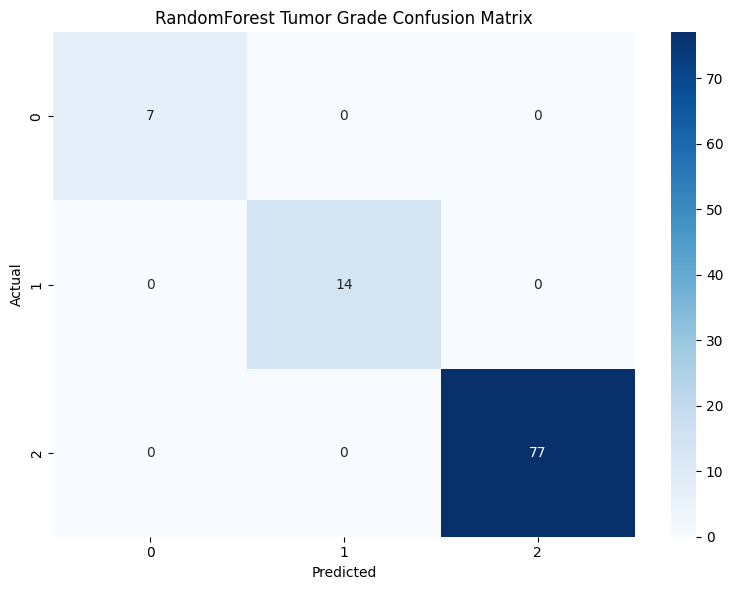

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Load data
clinical_df = pd.read_excel('../data/Clinical_and_Other_Features.xlsx', header=0, skiprows=[0, 2])
radiomic_df = pd.read_csv('extracted_radiomics_features.csv')
deep_df = pd.read_csv('efficientnet_features.csv')  # <-- from Step 2.3

# Merge all
merged_df = pd.merge(clinical_df, radiomic_df, on='Patient ID', how='inner')
merged_df = pd.merge(merged_df, deep_df, on='Patient ID', how='inner')

# Drop missing labels
merged_df = merged_df.dropna(subset=['Tumor Grade']).reset_index(drop=True)

# Load selected features (from 2.2)
selected_features = pd.read_csv('tumor_grade_features.csv')['tumor_grade_features'].tolist()

# Define X and y
X = merged_df[selected_features]
y = merged_df['Tumor Grade']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameters
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Grid Search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
joblib.dump(best_model, 'tumor_grade_model.pkl')

# Evaluate
y_pred = best_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# AFTER you train best_model on your new 100‑patient dataset:
pd.Series(X_train.columns).to_csv('rf_feature_columns_new.csv', index=False)


# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("RandomForest Tumor Grade Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
plt.close()

In [61]:
from sklearn.model_selection import train_test_split

filtered_paths  = []
filtered_labels = []
filtered_pids   = []

for path, pid in zip(dicom_paths, patient_ids):
    if pid in tumor_grade_dict:
        filtered_paths.append(path)
        filtered_labels.append(tumor_grade_dict[pid])
        filtered_pids.append(pid)


# Suppose you have:
#   filtered_paths, filtered_labels, patient_ids  — all length N_images
#   and you do:
X_train_paths, X_test_paths, y_train, y_test, pid_train, pid_test = train_test_split(
    filtered_paths, filtered_labels, filtered_pids,
    test_size=0.2, stratify=filtered_labels, random_state=42
)

# AND for your RF features you did something like:
features_df = merged_df[['Patient ID'] + selected_features]  # has Patient ID + all feature cols
X_feat = features_df[selected_features]
pid_feat = features_df['Patient ID']

X_feat_train, X_feat_test, y_feat_train, y_feat_test, pid_feat_train, pid_feat_test = train_test_split(
    X_feat, y, pid_feat,
    test_size=0.2, stratify=y, random_state=42
)

# Now save these WITH pid_test:
# 1) RF feature CSV
rf_test_df = X_feat_test.copy()
rf_test_df['PatientID'] = pid_feat_test.values
rf_test_df.to_csv('X_test_features.csv', index=False)

# 2) Image paths CSV
img_test_df = pd.DataFrame({
    'PatientID': pid_test,
    'file_path': X_test_paths
})
img_test_df.to_csv('X_test_image_paths.csv', index=False)

## Step 4: Deep Learning Tumor Grade Classification (EfficientNetB7)

/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-05-04 12:16:57.714352: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-05-04 12:16:57.814286: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-05-04 12:16:57.891218: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-05-04 12:16:57.994200: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2025-05-04 12:16:58.718810: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5891 - loss: 0.9628  
Epoch 1: val_accuracy improved from -inf to 0.78571, saving model to best_efficientnet_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 762s 15s/step - accuracy: 0.5910 - loss: 0.9609 - val_accuracy: 0.7857 - val_loss: 0.8091 - learning_rate: 1.0000e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7358 - loss: 1.0386  
Epoch 2: val_accuracy did not improve from 0.78571
49/49 ━━━━━━━━━━━━━━━━━━━━ 701s 14s/step - accuracy: 0.7363 - loss: 1.0357 - val_accuracy: 0.7857 - val_loss: 0.9128 - learning_rate: 1.0000e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7264 - loss: 0.8707  
Epoch 3: val_accuracy did not improve from 0.78571
49/49 ━━━━━━━━━━━━━━━━━━━━ 714s 15s/step - accuracy: 0.7265 - loss: 0.8704 - val_accuracy: 0.7857 - val_loss: 0.9197 - learning_rate: 1.0000e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7404 - loss: 0.8059  
Epoch 4: val_accuracy did not improve from 0.78571
49/49 ━━━━━━━━━━━━━━━━━━━━ 717s 15s/step - accuracy: 0.7409 - loss: 0.8059 - val_accuracy: 0.7857 - val_loss: 0.9548 - learning_rate: 1.0000e-04
Epoch 5/5

13/13 ━━━━━━━━━━━━━━━━━━━━ 163s 11s/step - accuracy: 0.7848 - loss: 0.8997
Test accuracy: 0.7857
13/13 ━━━━━━━━━━━━━━━━━━━━ 156s 12s/step


/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         7
         2.0       0.00      0.00      0.00        14
         3.0       0.79      1.00      0.88        77

    accuracy                           0.79        98
   macro avg       0.26      0.33      0.29        98
weighted avg       0.62      0.79      0.69        98



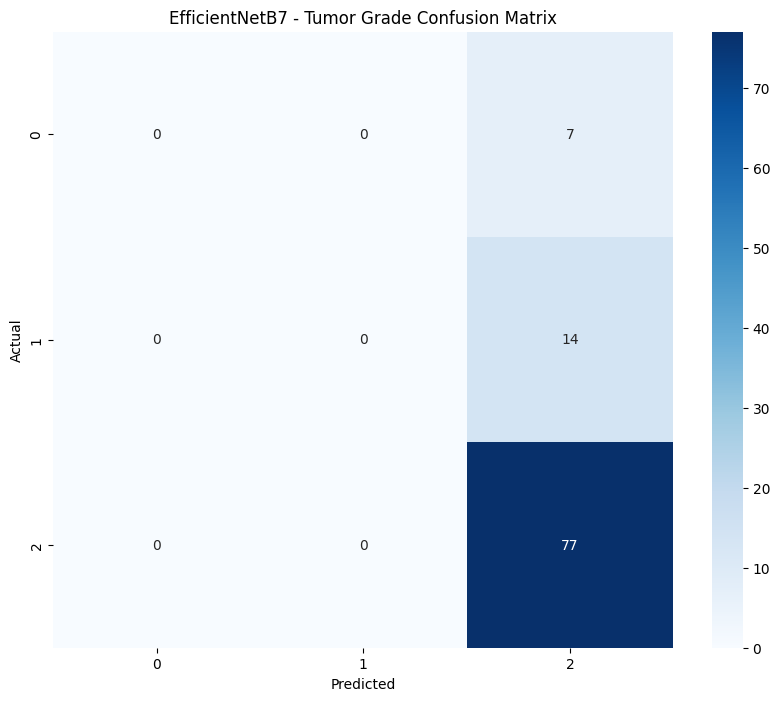

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pydicom

# Load clinical labels
clinical_df = pd.read_excel('../data/Clinical_and_Other_Features.xlsx', header=0, skiprows=[0, 2])

# DICOM paths and patient IDs
dataset_dir = '../data/Duke-Breast-Cancer-MRI'
dicom_paths, patient_ids = get_all_dicoms_per_patient(dataset_dir, max_patients=100, max_images_per_patient=5)

# Match tumor grade per image
tumor_grade_dict = clinical_df.set_index('Patient ID')['Tumor Grade'].dropna().to_dict()

# Keep only images with tumor grade labels
filtered_paths = []
filtered_labels = []

for path, pid in zip(dicom_paths, patient_ids):
    if pid in tumor_grade_dict:
        filtered_paths.append(path)
        filtered_labels.append(tumor_grade_dict[pid])

# Encode tumor grade labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_labels)

# Split dataset
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    filtered_paths, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Image loading
def load_dicom_images(file_paths, target_size=(600, 600)):
    images = []
    for path in file_paths:
        try:
            ds = pydicom.dcmread(path)
            img = ds.pixel_array.astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalize 0-1
            img = tf.image.resize(np.expand_dims(img, axis=-1), target_size)
            img = tf.image.grayscale_to_rgb(img)
            images.append(img.numpy())
        except:
            images.append(np.zeros(target_size + (3,)))
    return np.array(images)

# Data generator
class DicomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size=16, target_size=(600, 600), shuffle=True, num_classes=3):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_paths = [self.file_paths[k] for k in indexes]
        batch_labels = [self.labels[k] for k in indexes]
        X = load_dicom_images(batch_paths, self.target_size)
        y = tf.keras.utils.to_categorical(batch_labels, num_classes=self.num_classes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Initialize data generators
num_classes = len(np.unique(y_encoded))
train_generator = DicomDataGenerator(X_train_paths, y_train, batch_size=8, num_classes=num_classes)
test_generator = DicomDataGenerator(X_test_paths, y_test, batch_size=8, shuffle=False, num_classes=num_classes)

# Build model
def create_model(input_shape=(600, 600, 3), num_classes=3):
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze for initial training

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Train model
model = create_model(num_classes=num_classes)

callbacks = [
    ModelCheckpoint('best_efficientnet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=callbacks
)

# Evaluate
best_model = tf.keras.models.load_model('best_efficientnet_model.h5')
loss, acc = best_model.evaluate(test_generator)
print(f"Test accuracy: {acc:.4f}")

# Predictions and classification report
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test[:len(y_pred)]  # just in case of batch mismatch

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label_encoder.inverse_transform(y_true), label_encoder.inverse_transform(y_pred)))

# Confusion matrix
cm = confusion_matrix(label_encoder.inverse_transform(y_true), label_encoder.inverse_transform(y_pred))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('EfficientNetB7 - Tumor Grade Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()


## Step 5: Create Ensemble Model (CNN + RF) new efficientnet

2025-05-04 22:38:37.919779: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 22:38:39.193881: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 22:38:39.741311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746419920.265316  328010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746419920.443461  328010 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746419921.818762  328010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

✔️ After alignment: (98, 30)  (should be 98×30)
✔️ After fillna(median): (98, 30)  missing=98


2025-05-04 22:39:25.664655: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 423360000 exceeds 10% of free system memory.
2025-05-04 22:39:31.296978: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-05-04 22:39:32.198463: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-05-04 22:39:32.880223: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-05-04 22:39:33.252573: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


RF  Accuracy:       0.9694
CNN Accuracy:      0.7857
Ensemble Accuracy: 0.9592

Ensemble Classification Report:
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000         7
         2.0     1.0000    0.7143    0.8333        14
         3.0     0.9506    1.0000    0.9747        77

    accuracy                         0.9592        98
   macro avg     0.9835    0.9048    0.9360        98
weighted avg     0.9612    0.9592    0.9563        98



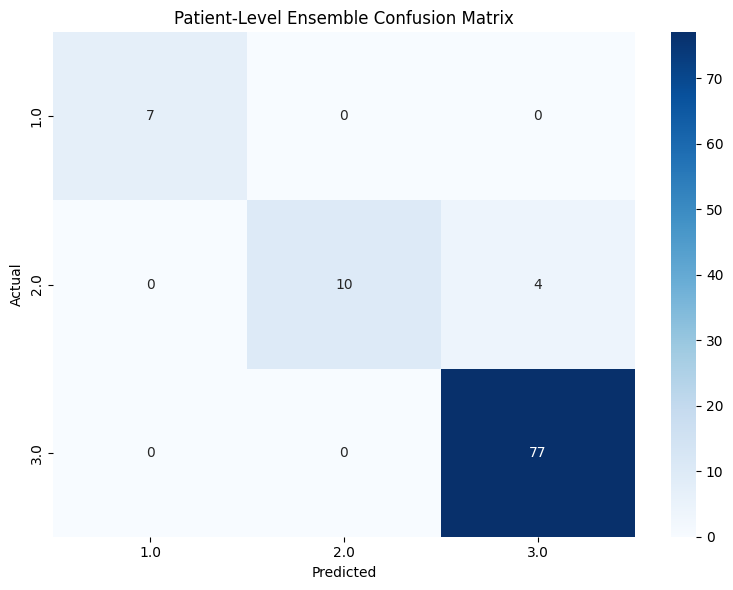

In [1]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import pydicom
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 1) Load models
# ------------------------------------------------------------------------------
rf_model  = joblib.load('tumor_grade_model.pkl')
cnn_model = tf.keras.models.load_model('best_efficientnet_model.h5')

# ------------------------------------------------------------------------------
# 2) Read test splits (must include PatientID)
# ------------------------------------------------------------------------------
feat_df = pd.read_csv('X_test_features.csv')      # PatientID + feature columns
img_df  = pd.read_csv('X_test_image_paths.csv')   # PatientID + file_path

# ------------------------------------------------------------------------------
# 3) Build ordered patient list and y_true
# ------------------------------------------------------------------------------
patients = feat_df['PatientID'].tolist()

clinical_df = pd.read_excel(
    '../data/Clinical_and_Other_Features.xlsx',
    header=0, skiprows=[0,2]
)
grade_map = clinical_df.set_index('Patient ID')['Tumor Grade'].to_dict()
y_true = np.array([grade_map[pid] for pid in patients])

# ------------------------------------------------------------------------------
# 4) Align RF feature matrix and fill missing features with zeros
# ------------------------------------------------------------------------------
expected = list(rf_model.feature_names_in_)
X_raw = feat_df.set_index('PatientID')

aligned = {}
missing = []
for col in expected:
    if col in X_raw.columns:
        aligned[col] = X_raw[col].values
    else:
        aligned[col] = np.zeros(len(patients), dtype=float)
        missing.append(col)

if missing:
    print(f"Filling {len(missing)} missing features with zeros:\n  {missing}")

X_pat = pd.DataFrame(aligned, index=patients)
print("After alignment:", X_pat.shape, " (should be 98×30)")

# ------------------------------------------------------------------------------
# 4b) Fill NaNs with column medians to preserve shape
# ------------------------------------------------------------------------------
meds = X_pat.median()
X_pat = X_pat.fillna(meds)
print("After fillna(median):", X_pat.shape, 
      f" missing={X_pat.isna().sum().sum()}")

# ------------------------------------------------------------------------------
# 5) RF predictions & probabilities
# ------------------------------------------------------------------------------
rf_probs = rf_model.predict_proba(X_pat)
rf_preds = rf_model.classes_[np.argmax(rf_probs, axis=1)]

# ------------------------------------------------------------------------------
# 6) CNN slice‑level → patient‑level aggregation
# ------------------------------------------------------------------------------
paths = img_df['file_path'].tolist()
pids  = img_df['PatientID'].tolist()

def load_images(paths, size=(600,600)):
    imgs = []
    for p in paths:
        try:
            ds = pydicom.dcmread(p)
            im = ds.pixel_array.astype(np.float32)
            im = (im - im.min())/(im.max()-im.min()+1e-6)
            im = tf.image.resize(im[...,None], size)
            im = tf.repeat(im,3,axis=-1).numpy()
        except:
            im = np.zeros(size+(3,),dtype=np.float32)
        imgs.append(im)
    return np.stack(imgs, axis=0)

cnn_img_probs = cnn_model.predict(load_images(paths), verbose=0)
cnn_df = pd.DataFrame(cnn_img_probs, columns=rf_model.classes_)
cnn_df['PatientID'] = pids

# mean across each patient’s images
cnn_probs = cnn_df.groupby('PatientID').mean().loc[patients].values
cnn_preds = rf_model.classes_[np.argmax(cnn_probs, axis=1)]

# ------------------------------------------------------------------------------
# 7) Soft‑voting ensemble
# ------------------------------------------------------------------------------
ens_probs = 0.5 * rf_probs + 0.5 * cnn_probs
ens_preds  = rf_model.classes_[np.argmax(ens_probs, axis=1)]

# ------------------------------------------------------------------------------
# 8) Evaluate & Plot
# ------------------------------------------------------------------------------
print(f"RF  Accuracy:       {accuracy_score(y_true, rf_preds):.4f}")
print(f"CNN Accuracy:      {accuracy_score(y_true, cnn_preds):.4f}")
print(f"Ensemble Accuracy: {accuracy_score(y_true, ens_preds):.4f}\n")

print("Ensemble Classification Report:")
print(classification_report(y_true, ens_preds, digits=4))

cm = confusion_matrix(y_true, ens_preds, labels=rf_model.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.title("Patient‑Level Ensemble Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Step 6: Model Interpretability

PermutationExplainer explainer: 99it [00:14,  1.97it/s]                         
/tmp/ipykernel_328010/1583451198.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
/tmp/ipykernel_328010/1583451198.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


SHAP values array shape: (98, 30, 3)


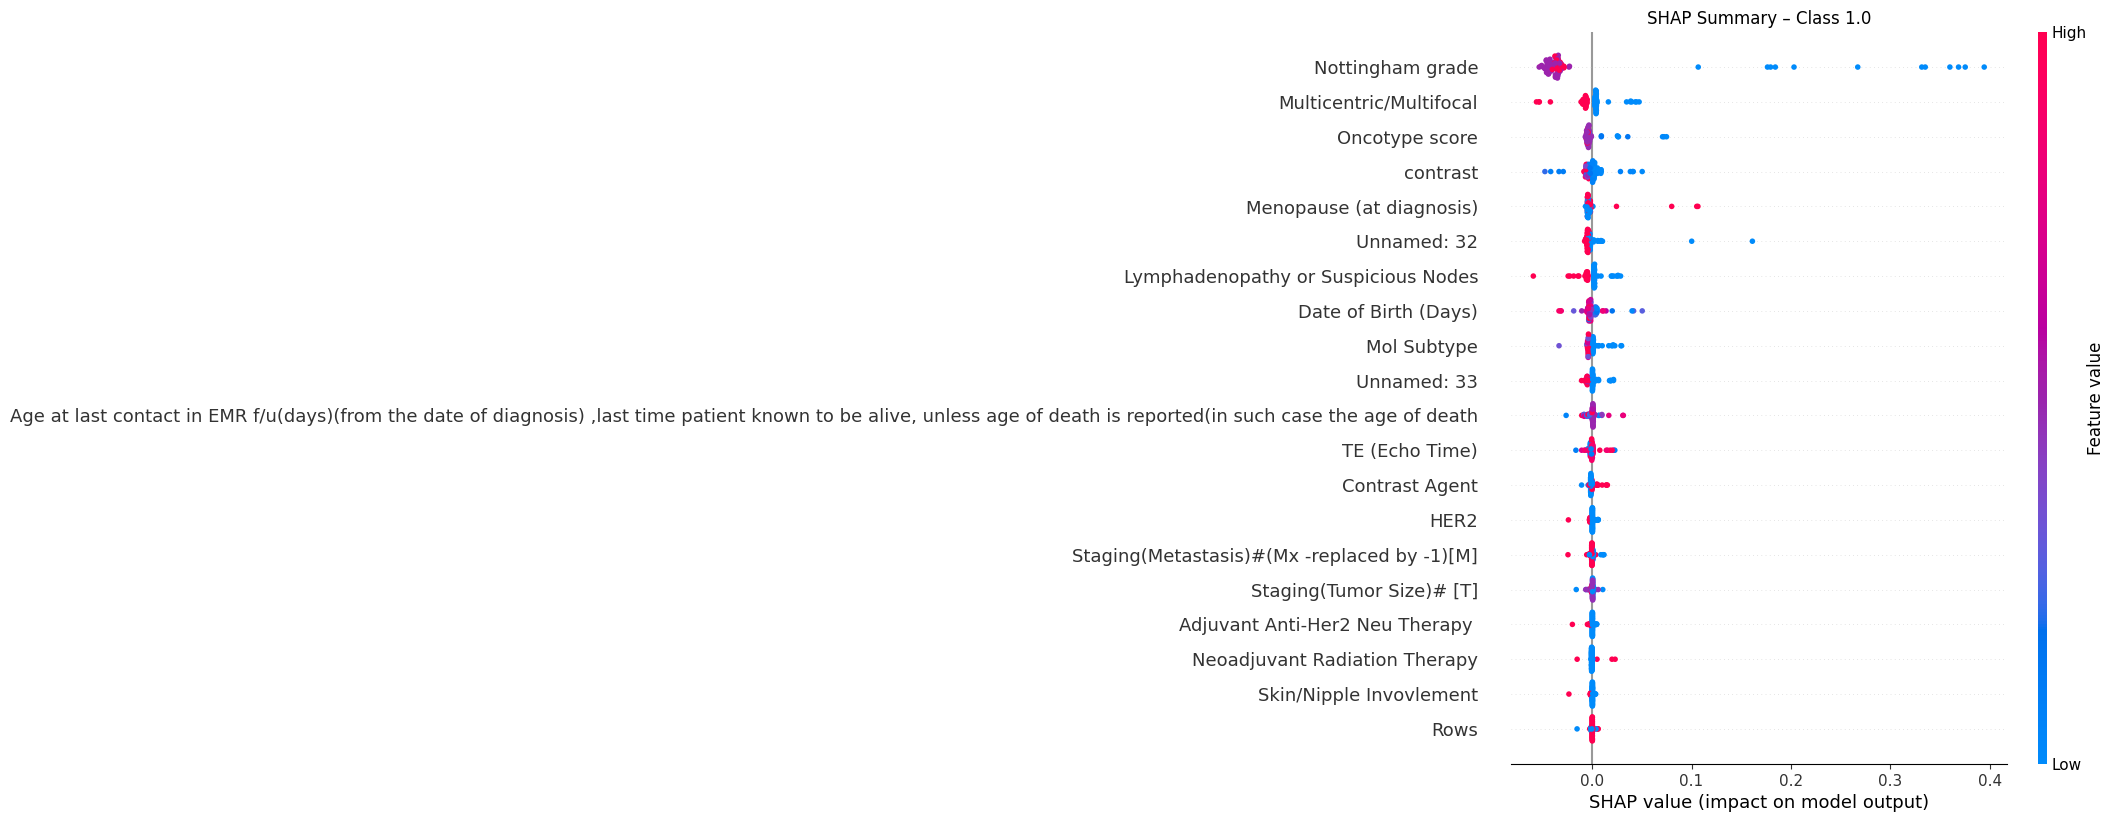

/tmp/ipykernel_328010/1583451198.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
/tmp/ipykernel_328010/1583451198.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


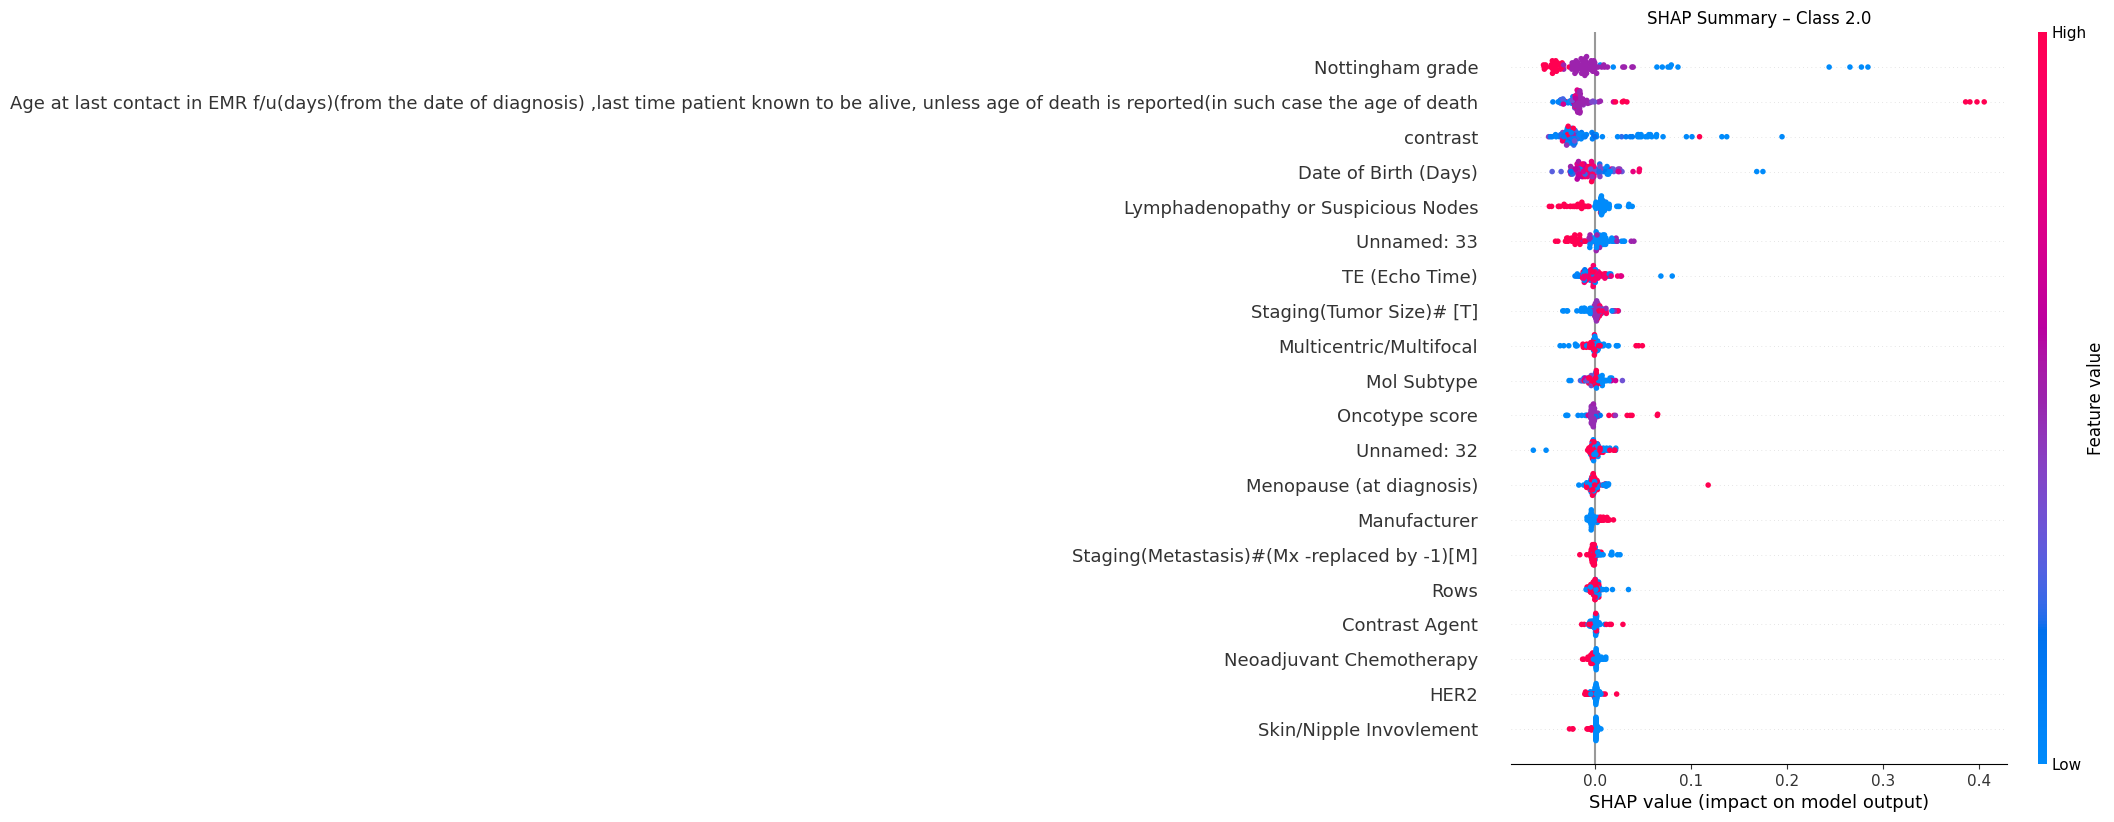

/tmp/ipykernel_328010/1583451198.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(
/home/ishit/miniconda3/envs/ml_hw/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1153: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()
/tmp/ipykernel_328010/1583451198.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


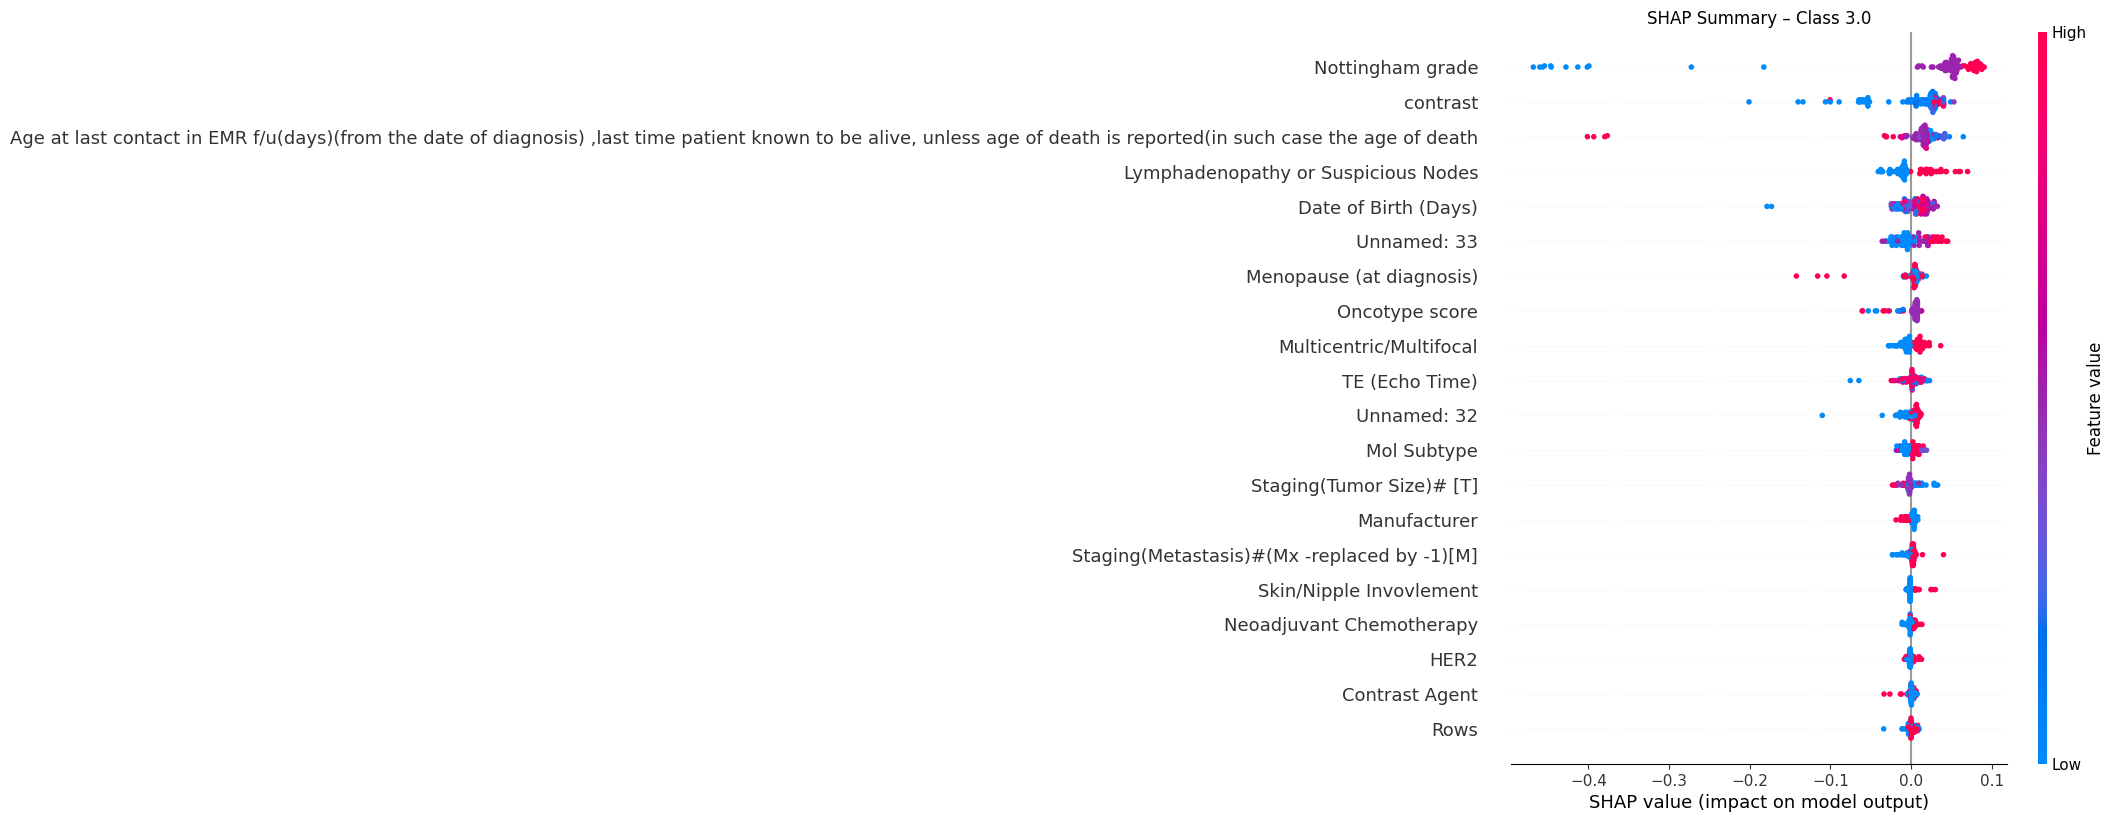

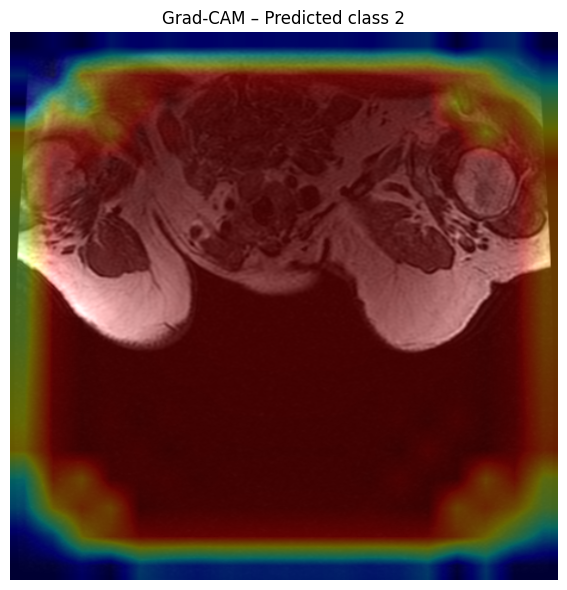

In [19]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import pydicom
import shap
import matplotlib.pyplot as plt
from matplotlib import cm

# ---- A) Load models ----
rf_pipeline = joblib.load('tumor_grade_model.pkl')       # RF pipeline (scaler + classifier)
cnn_model   = tf.keras.models.load_model('best_efficientnet_model.h5')

# ---- B) Prepare X_test for SHAP ----
feat_df = pd.read_csv('X_test_features.csv')
if 'PatientID' in feat_df.columns:
    feat_df = feat_df.drop(columns=['PatientID'])
expected = list(rf_pipeline.feature_names_in_)
X_test_feat = feat_df.reindex(columns=expected, fill_value=0).fillna(feat_df.median())

# ---- C) SHAP on predict_proba ----
masker    = shap.maskers.Independent(X_test_feat)
explainer = shap.Explainer(lambda x: rf_pipeline.predict_proba(x), masker)
shap_exp  = explainer(X_test_feat)   # shap_exp.values shape = (n_samples, n_features, n_classes)

print("SHAP values array shape:", shap_exp.values.shape)
# e.g. (98, 30, 3)

# Plot one summary per class
for i, cls in enumerate(rf_pipeline.classes_):
    plt.figure(figsize=(8,6))
    shap.summary_plot(
        shap_exp.values[:,:,i],
        X_test_feat,
        feature_names=expected,
        show=False
    )
    plt.title(f"SHAP Summary – Class {cls}")
    plt.tight_layout()
    plt.show()
    plt.close()


# ---- D) Grad‑CAM for EfficientNetB7 (rebuild functional model) ----

import tensorflow as tf
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from matplotlib import cm

# 1) Grab the Sequential’s first layer (the EfficientNetB7 base)
base_model = cnn_model.layers[0]

# 2) Create a new Input tensor matching your preprocessing
inp = tf.keras.Input(shape=(600, 600, 3))

# 3) Run it through the base model to get conv features
x = base_model(inp)
conv_out = x  # this is the feature‑map we’ll use for Grad‑CAM

# 4) Run through the rest of your Sequential
for layer in cnn_model.layers[1:]:
    x = layer(x)
final_out = x  # this is your softmax output

# 5) Build the grad‑model
grad_model = tf.keras.models.Model(inputs=inp, outputs=[conv_out, final_out])

# 6) Load & preprocess one DICOM
sample_path = pd.read_csv('X_test_image_paths.csv')['file_path'].iloc[0]
ds = pydicom.dcmread(sample_path)
img = ds.pixel_array.astype(np.float32)
img = (img - img.min())/(img.max()-img.min()+1e-6)
img_resized = tf.image.resize(img[...,None], (600,600))
img_rgb = tf.repeat(img_resized, 3, axis=-1).numpy()
input_tensor = np.expand_dims(img_rgb, 0)  # shape (1,600,600,3)

# 7) Compute Grad‑CAM
with tf.GradientTape() as tape:
    conv_maps, preds = grad_model(input_tensor)
    class_idx = tf.argmax(preds[0])
    loss = preds[:, class_idx]

grads   = tape.gradient(loss, conv_maps)[0]                   # (H, W, C)
weights = tf.reduce_mean(grads, axis=(0,1))                   # (C,)
cam     = tf.reduce_sum(tf.multiply(weights, conv_maps[0]), axis=-1)
cam     = tf.maximum(cam, 0) / (tf.reduce_max(cam) + 1e-6)     # normalize to [0,1]
heatmap = cam.numpy()                                         # (H, W)

# 8) Superimpose heatmap
heatmap_resized = tf.image.resize(heatmap[...,None], img_rgb.shape[:2]).numpy()[...,0]
heatmap_uint8    = np.uint8(255 * heatmap_resized)
heatmap_color    = cm.jet(heatmap_uint8)[:,:,:3]
overlay          = 0.4 * heatmap_color + img_rgb

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title(f"Grad‑CAM – Predicted class {int(class_idx)}")
plt.tight_layout()
plt.show()